<a href="https://colab.research.google.com/github/Sriras85/cnn-bilstm-attention/blob/master/CNN_BiLSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#Step 1
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Activation, Flatten, concatenate, Permute, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam, SGD

In [8]:
from google.colab import files

# This will prompt you to select a file from your local machine
uploaded = files.upload()

Saving Power data.csv to Power data (2).csv


In [10]:
df = pd.read_csv('Power data (2).csv')

df.head()

,Timestamp,Power_MW
0,1/1/2021 1:00,8549
1,1/1/2021 2:00,8338
2,1/1/2021 3:00,8175
3,1/1/2021 4:00,8161
4,1/1/2021 5:00,8298


In [4]:
# Sort the DataFrame by the 'Timestamp' column
df.sort_values(by='Timestamp', inplace=True)

# Reset the index to reflect the new order
df.reset_index(drop=True, inplace=True)

In [5]:

df

,Timestamp,Power_MW
0,1/1/2021 10:00,9860
1,1/1/2021 11:00,10136
2,1/1/2021 12:00,10153
3,1/1/2021 13:00,10122
4,1/1/2021 14:00,10053
...,...,...
22650,9/9/2022 5:00,7365
22651,9/9/2022 6:00,7438
22652,9/9/2022 7:00,7694
22653,9/9/2022 8:00,8077


In [11]:
# Function to detect and remove outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

# Remove outliers from the 'Normalized_Denoised_Power_Consumption_kW' column
data_no_outliers = remove_outliers_iqr(df, 'Power_MW')

# Use the cleaned data
power_cleaned = data_no_outliers['Power_MW'].values

In [12]:

#Step 3
# Split the data into training, validation, and test sets
n = len(data_no_outliers)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_data = data_no_outliers[:n_train].drop(columns=['Timestamp']).values
train_date = data_no_outliers[:n_train].drop(columns=['Power_MW'])

val_data   = data_no_outliers[n_train:n_train+n_val].drop(columns=['Timestamp']).values
val_date   = data_no_outliers[n_train:n_train+n_val].drop(columns=['Power_MW'])

test_data  = data_no_outliers[-n_test:].drop(columns=['Timestamp']).values
test_date  = data_no_outliers[-n_test:].drop(columns=['Power_MW'])

In [13]:

print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  17775
Validation Set :  2221
Test Set       :  2223


In [14]:
#Step 4
# Normalize the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

In [15]:
#Step 5
#Take day for predict from data test, 48 = 1 day

one_day_date = test_date.head(48)
one_day_data = test_data[:48]

three_day_date = test_date.head(144)
three_day_data = test_data[:144]

seven_day_date = test_date.head(336)
seven_day_data = test_data[:336]

In [16]:
#Step 6
#Create a windowed dataset for training
window_size = 48 # use 48 from interval one day of data for each window
def create_window_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [17]:

train_data

array([[-1.07694925],
       [-1.1677007 ],
       [-1.23780727],
       ...,
       [-0.0804037 ],
       [-0.15481129],
       [-0.25459487]])

In [18]:

original_data = scaler.inverse_transform(train_data)
original_data

array([[ 8549.],
       [ 8338.],
       [ 8175.],
       ...,
       [10866.],
       [10693.],
       [10461.]])

In [19]:

#Step 7
X_train, y_train = create_window_dataset(train_data, window_size)
X_val, y_val     = create_window_dataset(val_data, window_size)
X_test, y_test   = create_window_dataset(test_data, window_size)

In [20]:
@tf.keras.utils.register_keras_serializable()
def cc(y_true, y_pred):
    """
    Compute the correlation coefficient between y_true and y_pred.
    """
    # Compute the covariance matrix
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # Compute the standard deviation of y_true and y_pred
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # Compute the correlation coefficient
    return cov / (std_true * std_pred)

In [46]:

#Step 8b
from tensorflow.keras.layers import Layer
@keras.saving.register_keras_serializable()
class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_inputs = inputs * attention_weights
        if self.return_sequences:
            return weighted_inputs
        else:
            return tf.reduce_sum(weighted_inputs, axis=1)

In [30]:
## attempt1

In [22]:

input_shape = (window_size, 1)

model = Sequential([
    Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=input_shape),
    Conv1D(filters=8, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Attention(),
    #Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)
])

In [25]:

#Compile Model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.Huber(),
              metrics= [RootMeanSquaredError(), cc, mean_absolute_error, mean_squared_error ])

In [26]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])

Epoch 1/100
70/70 [==============================] - 32s 306ms/step - loss: 0.4248 - root_mean_squared_error: 0.9959 - cc: 0.6216 - mean_absolute_error: 0.8018 - mean_squared_error: 0.9917 - val_loss: 0.2683 - val_root_mean_squared_error: 0.7571 - val_cc: 0.2112 - val_mean_absolute_error: 0.6106 - val_mean_squared_error: 0.5732
Epoch 2/100
70/70 [==============================] - 20s 282ms/step - loss: 0.3433 - root_mean_squared_error: 0.8757 - cc: 0.6517 - mean_absolute_error: 0.7019 - mean_squared_error: 0.7668 - val_loss: 0.1434 - val_root_mean_squared_error: 0.5394 - val_cc: 0.3084 - val_mean_absolute_error: 0.4305 - val_mean_squared_error: 0.2909
Epoch 3/100
70/70 [==============================] - 20s 279ms/step - loss: 0.2495 - root_mean_squared_error: 0.7257 - cc: 0.6897 - mean_absolute_error: 0.5813 - mean_squared_error: 0.5267 - val_loss: 0.1222 - val_root_mean_squared_error: 0.4965 - val_cc: 0.4206 - val_mean_absolute_error: 0.4009 - val_mean_squared_error: 0.2465
Epoch 4/10

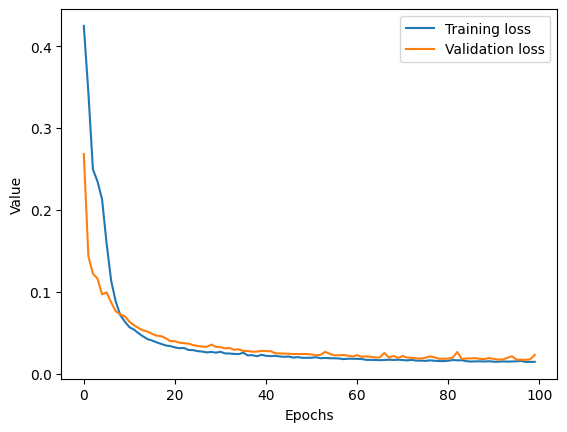

In [28]:

# Plot the training and validation metrics
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

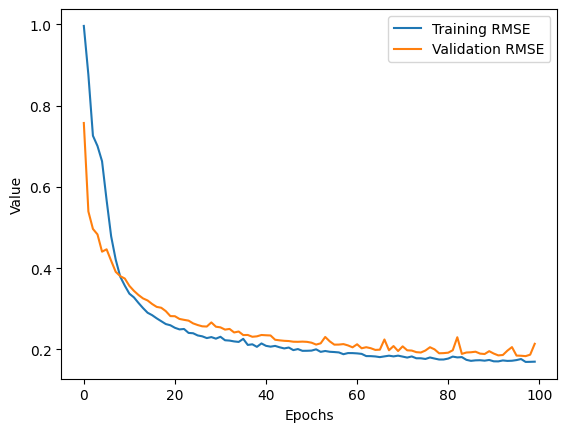

In [31]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

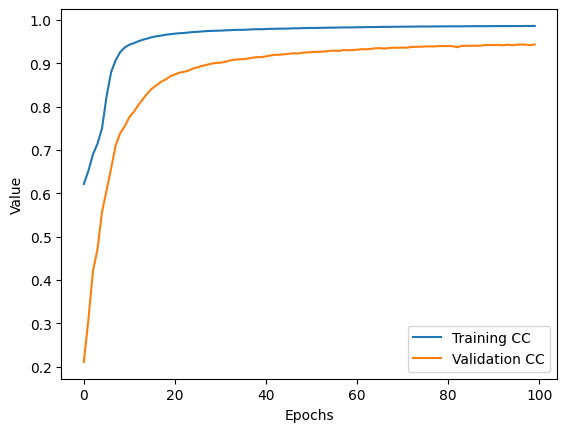

In [32]:
plt.plot(history.history['cc'], label='Training CC')
plt.plot(history.history['val_cc'], label='Validation CC')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

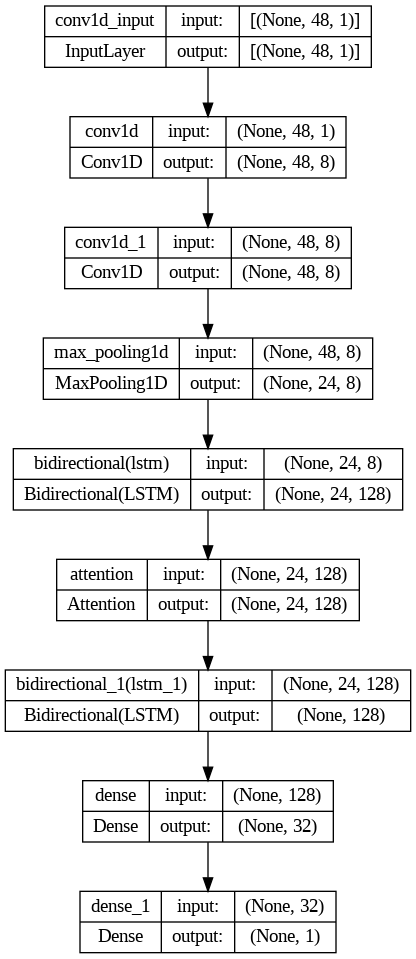

In [30]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc, test_mae, test_mse = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

68/68 [==============================] - 5s 16ms/step


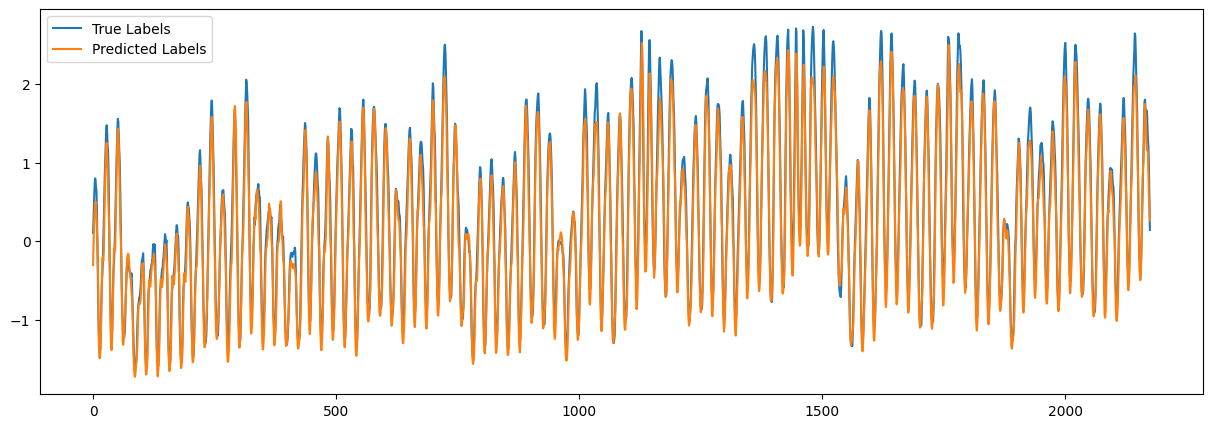

In [35]:
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.show()

In [37]:
#Evaluate the model on the 1, 3, 7 Days to Forecast
X_one   = X_test[:48]
X_three = X_test[:144]
X_seven = X_test[:336]

y_one   = y_test[:48]
y_three = y_test[:144]
y_seven = y_test[:336]

print("1 Day to Forecast")
test_loss, test_rmse, test_cc, test_mae, test_mse = model.evaluate(X_one, y_one)
y_pred_one = model.predict(X_one)


print("3 Days to Forecast")
test_loss, test_rmse, test_cc, test_mae, test_mse = model.evaluate(X_three, y_three)
y_pred_three = model.predict(X_three)

print("7 Days to Forecast")
test_loss, test_rmse, test_cc, test_mae, test_mse = model.evaluate(X_seven, y_seven)
y_pred_seven = model.predict(X_seven)

1 Day to Forecast
2/2 [==============================] - 0s 22ms/step
3 Days to Forecast
5/5 [==============================] - 0s 26ms/step
7 Days to Forecast
11/11 [==============================] - 0s 15ms/step


In [38]:
#Inverse from scaled data
inv_pred_one = scaler.inverse_transform(y_pred_one)
inv_one      = scaler.inverse_transform(y_one)

inv_pred_three = scaler.inverse_transform(y_pred_three)
inv_three      = scaler.inverse_transform(y_three)

inv_pred_seven = scaler.inverse_transform(y_pred_seven)
inv_seven      = scaler.inverse_transform(y_seven)

#Copy data date
viz_one   = one_day_date.copy()
viz_three = three_day_date.copy()
viz_seven = seven_day_date.copy()

#Join true and predicted data
viz_one['load_pred'] = inv_pred_one
viz_one['load_true'] = inv_one

viz_three['load_pred'] = inv_pred_three
viz_three['load_true'] = inv_three

viz_seven['load_pred'] = inv_pred_seven
viz_seven['load_true'] = inv_seven

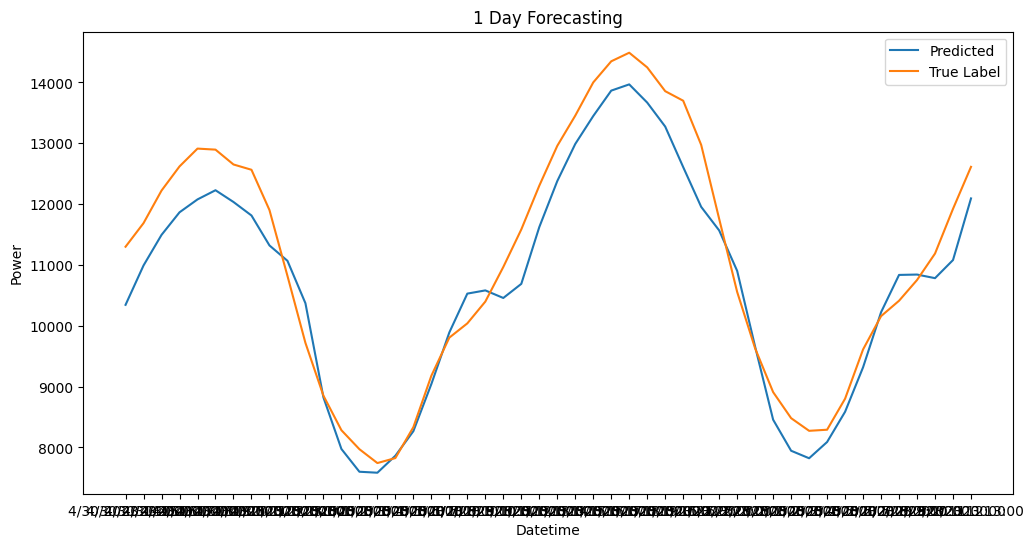

In [39]:
#1 Day Forecasting

# Load dataset
viz_one = viz_one.set_index('Timestamp')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_one.index, viz_one['load_pred'], label='Predicted')
ax.plot(viz_one.index, viz_one['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Power')
ax.set_title('1 Day Forecasting')
ax.legend()

# Show plot
plt.show()

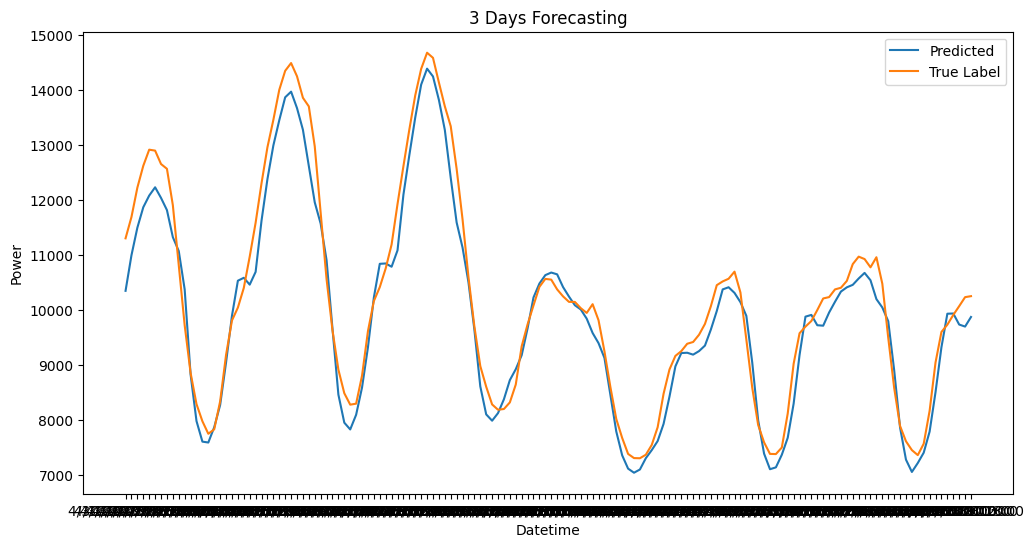

In [40]:
#3 Days Forecasting

# Load dataset
viz_three = viz_three.set_index('Timestamp')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_three.index, viz_three['load_pred'], label='Predicted')
ax.plot(viz_three.index, viz_three['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Power')
ax.set_title('3 Days Forecasting')
ax.legend()

# Show plot
plt.show()

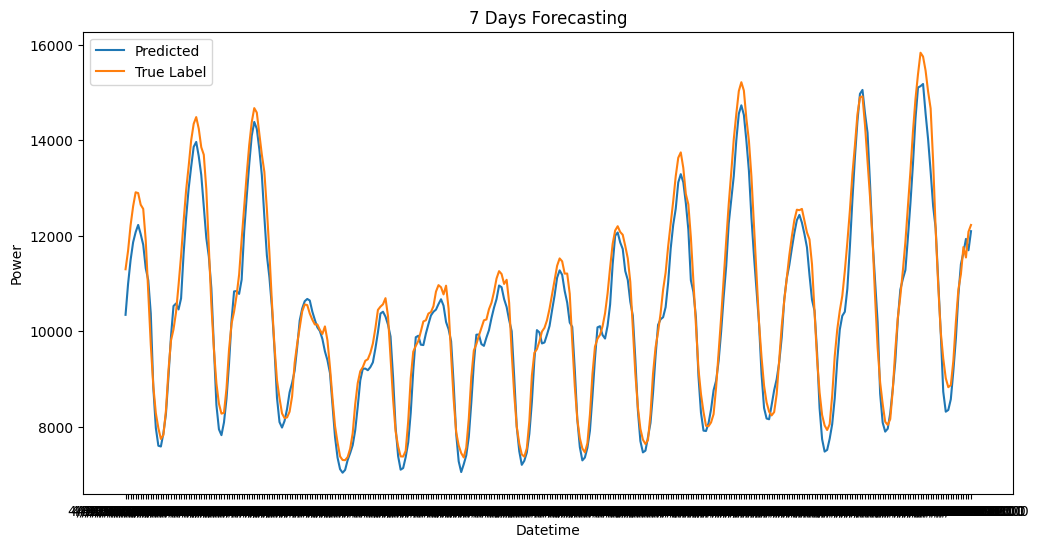

In [41]:
#7 Days Forecasting

# Load dataset
viz_seven = viz_seven.set_index('Timestamp')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_seven.index, viz_seven['load_pred'], label='Predicted')
ax.plot(viz_seven.index, viz_seven['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Power')
ax.set_title('7 Days Forecasting')
ax.legend()

# Show plot
plt.show()

In [43]:
import pickle
import os

# Check if the directory exists, if not create it
model_dir = '/content/drive/MyDrive/Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the trained model
model.save(os.path.join(model_dir, 'CNN_BiLSTM_Atten_Model_Final.keras'))

# Save the history object
with open(os.path.join(model_dir, 'CNN_BiLSTM_Atten_Model_history_Final.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

In [55]:
import tensorflow as tf
#from keras.saving.saving_utils import register_keras_serializable
from tensorflow.keras.utils import plot_model, register_keras_serializable
from tensorflow.keras.layers import Layer

# Assuming 'Attention' is your custom layer class
@register_keras_serializable()
class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_inputs = inputs * attention_weights
        if self.return_sequences:
            return weighted_inputs
        else:
            return tf.reduce_sum(weighted_inputs, axis=1)


# Load the saved model
model_load = tf.keras.models.load_model('/content/drive/MyDrive/Model/CNN_BiLSTM_Atten_Model_Final.keras',
                                   custom_objects={'Attention': Attention})

# Now you can summarize the model
model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 8)             16        
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 8)             72        
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 8)             0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 24, 128)           37376     
 al)                                                             
                                                                 
 attention_1 (Attention)     (None, 24, 128)           128       
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               9